- This notebook is to use rdkit fingerprints as base model to test performance on amphiphiles dataset

In [1]:
import sys
sys.path.append("../src/models")
sys.path.append("../src")
sys.path.append("../")

In [2]:
import pandas as pd
import numpy as np

In [3]:
from utils import *
from baseline import *

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
file_path='/Users/haoliu/Documents/GitHub/MicroscopyAnalysis/df_input_update_ori_20240812.csv'
df_input_update_ori = pd.read_csv(file_path) 
df_input = df_input_update_ori.copy()
df_input.iloc[:,0:7] = df_input.iloc[:,0:7].applymap(lambda x: np.log1p(x))
df_input=df_input.iloc[:, 0:8]
df_input

/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_71164/3858243564.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_input.iloc[:,0:7] = df_input.iloc[:,0:7].applymap(lambda x: np.log1p(x))


,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles
0,0.615186,0.955511,1.231101,1.552868,1.677097,0.441476,0.579418,22
1,1.487270,0.644482,0.175633,1.056053,1.216395,0.207827,0.107059,9
2,1.163151,0.705570,1.294727,1.787584,1.658228,0.159138,0.202941,6
3,1.531476,1.787584,0.381855,0.071390,1.475907,0.589175,0.113329,2
4,1.170933,1.441019,1.677097,0.885832,1.011601,0.750236,0.300105,36
...,...,...,...,...,...,...,...,...
331,0.112435,0.107957,0.009950,0.639219,1.020651,0.000000,0.007968,0
332,0.019803,0.006976,0.064851,0.916291,0.821980,0.033918,0.045929,59
333,0.137150,0.076961,0.043059,0.548121,1.090244,0.013410,0.018822,2
334,0.013903,0.028587,0.092579,0.693147,0.974560,0.049742,0.036332,15


In [13]:
info_path = '/Users/haoliu/Documents/Hao/Fordham/Cheminformatics/MD/Amphiphiles/Info.csv'
df_info = pd.read_csv(info_path)

df = df_input.copy()
df.columns = [col.replace('_Concentration (mM)', '') for col in df.columns[:-1]] + ['num_vesicles']

# Step 2: Create mapping from df_input_update_ori column names to df_info["Name"]
column_to_name = {
    'decanoic acid': 'Decanoic acid',
    'decanoate': 'Decanoate',
    'decylamine': 'Decylamine',
    'decyl trimethylamine': 'Decyltrimethyl ammonium bromid',
    'decylsulfate': 'Decyl sodium sulfate',
    'decanol': 'Decanol',
    'monocaprin': 'Glycerol monodecanoate'
}

# Step 3: Get SMILES mapping from df_info
name_to_smiles = dict(zip(df_info['Name'], df_info['SMILES']))

# Step 4: Construct new dataframe
new_data = {}

for col in df.columns[:-1]:  # Skip num_vesicles
    chem_name = column_to_name[col]
    smiles = name_to_smiles.get(chem_name, '')
    new_data[f"{col}_SMILES"] = [smiles] * len(df)
    new_data[f"{col}_Concentration"] = df[col]

# Step 5: Add num_vesicles
new_data['num_vesicles'] = df['num_vesicles']

# Step 6: Create the final dataframe
df_structured = pd.DataFrame(new_data)

# Rename columns to the desired format
new_column_names = [
    'smi1', 'conc1',
    'smi2', 'conc2',
    'smi3', 'conc3',
    'smi4', 'conc4',
    'smi5', 'conc5',
    'smi6', 'conc6',
    'smi7', 'conc7',
    'vesicles_formation'
]

# Apply the new column names
df_structured.columns = new_column_names
df_structured

,smi1,conc1,smi2,conc2,smi3,conc3,smi4,conc4,smi5,conc5,smi6,conc6,smi7,conc7,vesicles_formation
0,CCCCCCCCCC(=O)O,0.615186,CCCCCCCCCC(=O)[O-],0.955511,CCCCCCCCCCN,1.231101,CCCCCCCCCC[N+](C)(C)C.[Br-],1.552868,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],1.677097,CCCCCCCCCCO,0.441476,CCCCCCCCCC(=O)OCC(CO)O,0.579418,22
1,CCCCCCCCCC(=O)O,1.487270,CCCCCCCCCC(=O)[O-],0.644482,CCCCCCCCCCN,0.175633,CCCCCCCCCC[N+](C)(C)C.[Br-],1.056053,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],1.216395,CCCCCCCCCCO,0.207827,CCCCCCCCCC(=O)OCC(CO)O,0.107059,9
2,CCCCCCCCCC(=O)O,1.163151,CCCCCCCCCC(=O)[O-],0.705570,CCCCCCCCCCN,1.294727,CCCCCCCCCC[N+](C)(C)C.[Br-],1.787584,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],1.658228,CCCCCCCCCCO,0.159138,CCCCCCCCCC(=O)OCC(CO)O,0.202941,6
3,CCCCCCCCCC(=O)O,1.531476,CCCCCCCCCC(=O)[O-],1.787584,CCCCCCCCCCN,0.381855,CCCCCCCCCC[N+](C)(C)C.[Br-],0.071390,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],1.475907,CCCCCCCCCCO,0.589175,CCCCCCCCCC(=O)OCC(CO)O,0.113329,2
4,CCCCCCCCCC(=O)O,1.170933,CCCCCCCCCC(=O)[O-],1.441019,CCCCCCCCCCN,1.677097,CCCCCCCCCC[N+](C)(C)C.[Br-],0.885832,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],1.011601,CCCCCCCCCCO,0.750236,CCCCCCCCCC(=O)OCC(CO)O,0.300105,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,CCCCCCCCCC(=O)O,0.112435,CCCCCCCCCC(=O)[O-],0.107957,CCCCCCCCCCN,0.009950,CCCCCCCCCC[N+](C)(C)C.[Br-],0.639219,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],1.020651,CCCCCCCCCCO,0.000000,CCCCCCCCCC(=O)OCC(CO)O,0.007968,0
332,CCCCCCCCCC(=O)O,0.019803,CCCCCCCCCC(=O)[O-],0.006976,CCCCCCCCCCN,0.064851,CCCCCCCCCC[N+](C)(C)C.[Br-],0.916291,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],0.821980,CCCCCCCCCCO,0.033918,CCCCCCCCCC(=O)OCC(CO)O,0.045929,59
333,CCCCCCCCCC(=O)O,0.137150,CCCCCCCCCC(=O)[O-],0.076961,CCCCCCCCCCN,0.043059,CCCCCCCCCC[N+](C)(C)C.[Br-],0.548121,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],1.090244,CCCCCCCCCCO,0.013410,CCCCCCCCCC(=O)OCC(CO)O,0.018822,2
334,CCCCCCCCCC(=O)O,0.013903,CCCCCCCCCC(=O)[O-],0.028587,CCCCCCCCCCN,0.092579,CCCCCCCCCC[N+](C)(C)C.[Br-],0.693147,CCCCCCCCCCOS(=O)(=O)[O-].[Na+],0.974560,CCCCCCCCCCO,0.049742,CCCCCCCCCC(=O)OCC(CO)O,0.036332,15


In [14]:
for i in range(1, 8):
    col_name = f'smi{i}'
    df_structured[col_name] = df_structured[col_name].apply(smiles_to_fp)

In [15]:
print(df_structured['smi1'][0].shape)

(2048,)


In [14]:
df_structured.to_csv('df_structured_baseline_20250527.csv', index=False)

In [5]:
df_structured = pd.read_csv('df_structured_baseline_20250527.csv')

In [9]:
df_structured.head()

,smi1,conc1,smi2,conc2,smi3,conc3,smi4,conc4,smi5,conc5,smi6,conc6,smi7,conc7,vesicles_formation
0,[0 0 0 ... 0 0 0],0.615186,[0 0 0 ... 0 0 0],0.955511,[0 0 0 ... 0 0 1],1.231101,[0 0 0 ... 0 0 1],1.552868,[0 0 0 ... 0 0 0],1.677097,[0 0 0 ... 0 0 0],0.441476,[0 0 1 ... 0 0 0],0.579418,22
1,[0 0 0 ... 0 0 0],1.487270,[0 0 0 ... 0 0 0],0.644482,[0 0 0 ... 0 0 1],0.175633,[0 0 0 ... 0 0 1],1.056053,[0 0 0 ... 0 0 0],1.216395,[0 0 0 ... 0 0 0],0.207827,[0 0 1 ... 0 0 0],0.107059,9
2,[0 0 0 ... 0 0 0],1.163151,[0 0 0 ... 0 0 0],0.705570,[0 0 0 ... 0 0 1],1.294727,[0 0 0 ... 0 0 1],1.787584,[0 0 0 ... 0 0 0],1.658228,[0 0 0 ... 0 0 0],0.159138,[0 0 1 ... 0 0 0],0.202941,6
3,[0 0 0 ... 0 0 0],1.531476,[0 0 0 ... 0 0 0],1.787584,[0 0 0 ... 0 0 1],0.381855,[0 0 0 ... 0 0 1],0.071390,[0 0 0 ... 0 0 0],1.475907,[0 0 0 ... 0 0 0],0.589175,[0 0 1 ... 0 0 0],0.113329,2
4,[0 0 0 ... 0 0 0],1.170933,[0 0 0 ... 0 0 0],1.441019,[0 0 0 ... 0 0 1],1.677097,[0 0 0 ... 0 0 1],0.885832,[0 0 0 ... 0 0 0],1.011601,[0 0 0 ... 0 0 0],0.750236,[0 0 1 ... 0 0 0],0.300105,36


In [16]:
df_structured.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   smi1                336 non-null    object 
 1   conc1               336 non-null    float64
 2   smi2                336 non-null    object 
 3   conc2               336 non-null    float64
 4   smi3                336 non-null    object 
 5   conc3               336 non-null    float64
 6   smi4                336 non-null    object 
 7   conc4               336 non-null    float64
 8   smi5                336 non-null    object 
 9   conc5               336 non-null    float64
 10  smi6                336 non-null    object 
 11  conc6               336 non-null    float64
 12  smi7                336 non-null    object 
 13  conc7               336 non-null    float64
 14  vesicles_formation  336 non-null    int64  
dtypes: float64(7), int64(1), object(7)
memory usage: 39.5+ KB

In [6]:
df_structured_cls = binarize_last_column(df_structured)
df_structured_cls

,smi1,conc1,smi2,conc2,smi3,conc3,smi4,conc4,smi5,conc5,smi6,conc6,smi7,conc7,vesicles_formation
0,[0 0 0 ... 0 0 0],0.615186,[0 0 0 ... 0 0 0],0.955511,[0 0 0 ... 0 0 1],1.231101,[0 0 0 ... 0 0 1],1.552868,[0 0 0 ... 0 0 0],1.677097,[0 0 0 ... 0 0 0],0.441476,[0 0 1 ... 0 0 0],0.579418,1
1,[0 0 0 ... 0 0 0],1.487270,[0 0 0 ... 0 0 0],0.644482,[0 0 0 ... 0 0 1],0.175633,[0 0 0 ... 0 0 1],1.056053,[0 0 0 ... 0 0 0],1.216395,[0 0 0 ... 0 0 0],0.207827,[0 0 1 ... 0 0 0],0.107059,1
2,[0 0 0 ... 0 0 0],1.163151,[0 0 0 ... 0 0 0],0.705570,[0 0 0 ... 0 0 1],1.294727,[0 0 0 ... 0 0 1],1.787584,[0 0 0 ... 0 0 0],1.658228,[0 0 0 ... 0 0 0],0.159138,[0 0 1 ... 0 0 0],0.202941,1
3,[0 0 0 ... 0 0 0],1.531476,[0 0 0 ... 0 0 0],1.787584,[0 0 0 ... 0 0 1],0.381855,[0 0 0 ... 0 0 1],0.071390,[0 0 0 ... 0 0 0],1.475907,[0 0 0 ... 0 0 0],0.589175,[0 0 1 ... 0 0 0],0.113329,1
4,[0 0 0 ... 0 0 0],1.170933,[0 0 0 ... 0 0 0],1.441019,[0 0 0 ... 0 0 1],1.677097,[0 0 0 ... 0 0 1],0.885832,[0 0 0 ... 0 0 0],1.011601,[0 0 0 ... 0 0 0],0.750236,[0 0 1 ... 0 0 0],0.300105,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,[0 0 0 ... 0 0 0],0.112435,[0 0 0 ... 0 0 0],0.107957,[0 0 0 ... 0 0 1],0.009950,[0 0 0 ... 0 0 1],0.639219,[0 0 0 ... 0 0 0],1.020651,[0 0 0 ... 0 0 0],0.000000,[0 0 1 ... 0 0 0],0.007968,0
332,[0 0 0 ... 0 0 0],0.019803,[0 0 0 ... 0 0 0],0.006976,[0 0 0 ... 0 0 1],0.064851,[0 0 0 ... 0 0 1],0.916291,[0 0 0 ... 0 0 0],0.821980,[0 0 0 ... 0 0 0],0.033918,[0 0 1 ... 0 0 0],0.045929,1
333,[0 0 0 ... 0 0 0],0.137150,[0 0 0 ... 0 0 0],0.076961,[0 0 0 ... 0 0 1],0.043059,[0 0 0 ... 0 0 1],0.548121,[0 0 0 ... 0 0 0],1.090244,[0 0 0 ... 0 0 0],0.013410,[0 0 1 ... 0 0 0],0.018822,1
334,[0 0 0 ... 0 0 0],0.013903,[0 0 0 ... 0 0 0],0.028587,[0 0 0 ... 0 0 1],0.092579,[0 0 0 ... 0 0 1],0.693147,[0 0 0 ... 0 0 0],0.974560,[0 0 0 ... 0 0 0],0.049742,[0 0 1 ... 0 0 0],0.036332,1


In [17]:
def build_feature_vector(df, smi_cols, conc_cols):
    components = [df[smi].apply(pd.Series).mul(df[conc], axis=0) for smi, conc in zip(smi_cols, conc_cols)]
    return sum(components)
    
# List of columns to process
smi_cols = [f'smi{i}' for i in range(1, 8)]
conc_cols = [f'conc{i}' for i in range(1, 8)]

X = build_feature_vector(df_structured, smi_cols, conc_cols)

In [18]:
y = df_structured_cls['vesicles_formation'].values

In [31]:
X

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.0,0.0,0.579418,0.0,0.0,0.579418,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.783969
1,0.0,0.0,0.107059,0.0,0.0,0.107059,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.231685
2,0.0,0.0,0.202941,0.0,0.0,0.202941,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.082311
3,0.0,0.0,0.113329,0.0,0.0,0.113329,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.453245
4,0.0,0.0,0.300105,0.0,0.0,0.300105,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.562928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,0.0,0.0,0.007968,0.0,0.0,0.007968,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.649169
332,0.0,0.0,0.045929,0.0,0.0,0.045929,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.981142
333,0.0,0.0,0.018822,0.0,0.0,0.018822,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.591181
334,0.0,0.0,0.036332,0.0,0.0,0.036332,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.785726


In [22]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

In [21]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.68      0.72        28
           1       0.79      0.85      0.82        40

    accuracy                           0.78        68
   macro avg       0.78      0.76      0.77        68
weighted avg       0.78      0.78      0.78        68

[[19  9]
 [ 6 34]]


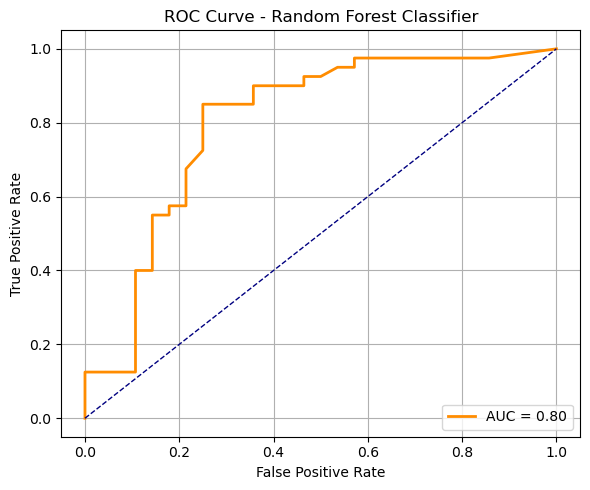

In [22]:
y_probs = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
y_probs

array([0.78, 0.4 , 0.03, 0.79, 0.53, 0.9 , 0.  , 0.34, 0.  , 0.43, 0.25,
       0.81, 1.  , 0.66, 0.88, 0.12, 0.69, 0.79, 0.4 , 0.47, 0.66, 0.51,
       0.39, 0.63, 0.38, 0.99, 0.5 , 0.78, 0.  , 0.26, 0.97, 0.44, 0.61,
       0.7 , 0.79, 0.  , 0.64, 0.96, 0.91, 0.23, 0.34, 0.72, 0.82, 0.22,
       0.71, 0.7 , 0.01, 0.95, 0.87, 0.82, 0.18, 0.66, 0.85, 0.78, 0.54,
       0.99, 0.82, 0.63, 0.88, 1.  , 0.8 , 0.9 , 0.33, 0.15, 0.  , 0.87,
       0.75, 0.69])

(array([ 7.,  3.,  4.,  5.,  5.,  4., 11.,  9., 10., 10.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

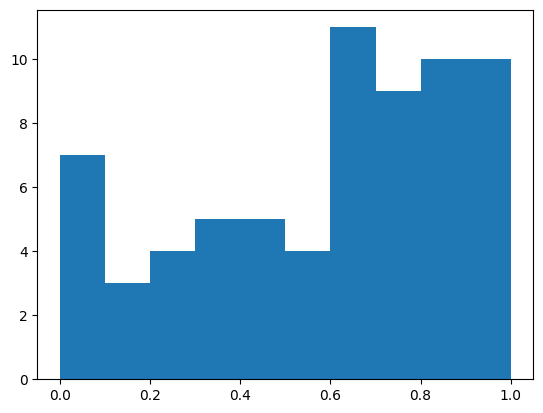

In [27]:
plt.hist(y_probs)

In [ ]:
# Repeat runs

In [33]:
df_structured_cls['vesicles_formation']

0      1
1      1
2      1
3      1
4      1
      ..
331    0
332    1
333    1
334    1
335    1
Name: vesicles_formation, Length: 336, dtype: int64

In [19]:
df_stable=pd.concat([X, df_structured_cls['vesicles_formation']], axis=1)
df_stable

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,vesicles_formation
0,0.0,0.0,0.579418,0.0,0.0,0.579418,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.783969,1
1,0.0,0.0,0.107059,0.0,0.0,0.107059,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.231685,1
2,0.0,0.0,0.202941,0.0,0.0,0.202941,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.082311,1
3,0.0,0.0,0.113329,0.0,0.0,0.113329,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.453245,1
4,0.0,0.0,0.300105,0.0,0.0,0.300105,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.562928,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,0.0,0.0,0.007968,0.0,0.0,0.007968,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.649169,0
332,0.0,0.0,0.045929,0.0,0.0,0.045929,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.981142,1
333,0.0,0.0,0.018822,0.0,0.0,0.018822,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.591181,1
334,0.0,0.0,0.036332,0.0,0.0,0.036332,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.785726,1


In [20]:
df_stable.to_csv('df_total_amphiphiles_baseline_20250710.csv', index=False)

In [3]:
import pandas as pd

In [4]:
df_stable = pd.read_csv('df_total_amphiphiles_baseline_20250710.csv')
df_stable

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,vesicles_formation
0,0.0,0.0,0.579418,0.0,0.0,0.579418,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.783969,1
1,0.0,0.0,0.107059,0.0,0.0,0.107059,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.231685,1
2,0.0,0.0,0.202941,0.0,0.0,0.202941,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.082311,1
3,0.0,0.0,0.113329,0.0,0.0,0.113329,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.453245,1
4,0.0,0.0,0.300105,0.0,0.0,0.300105,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.562928,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,0.0,0.0,0.007968,0.0,0.0,0.007968,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.649169,0
332,0.0,0.0,0.045929,0.0,0.0,0.045929,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.981142,1
333,0.0,0.0,0.018822,0.0,0.0,0.018822,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.591181,1
334,0.0,0.0,0.036332,0.0,0.0,0.036332,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.785726,1


/Users/haoliu/anaconda3/envs/fm4m/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haoliu/anaconda3/envs/fm4m/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haoliu/anaconda3/envs/fm4m/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haoliu/anaconda3/envs/fm4m/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed whe

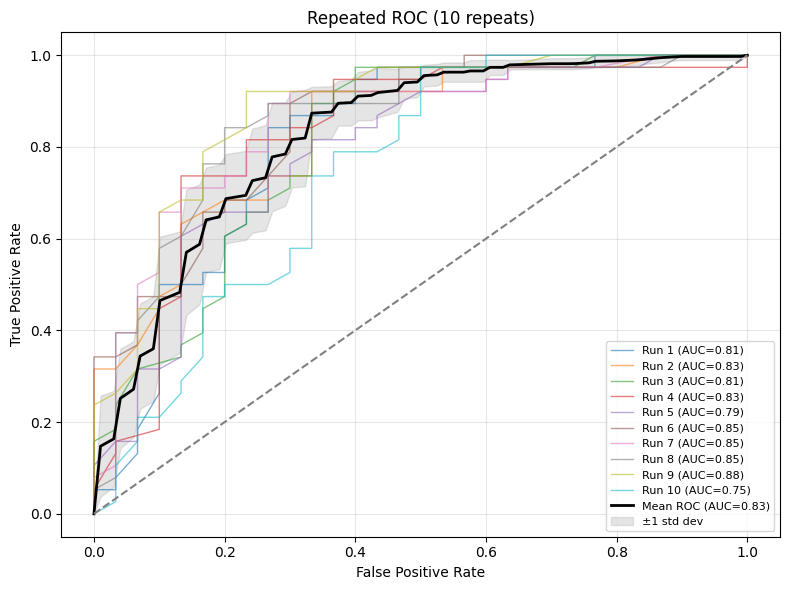

Mean AUC over 10 runs: 0.826 ± 0.036


In [17]:
evaluate_model_stability_baseline(df_stable, n_repeats=10)